In [1]:
import pandas as pd
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
from random import random
from io_utils import *

In [2]:
from LightCurve import LightCurve

In [3]:
data_ob = load_RESSPECT_data()
object_ids = data_ob.get_all_object_ids()

In [11]:
event_type = np.unique(data_ob.df_metadata['type'])

In [21]:
data_ob.df_metadata

SNID,redshift,type,code,sample
float64,float64,str10,float64,str5
6612.0,0.41613463,II_V19,42.0,train
7860.0,0.23487686,II-NMF,42.0,train
3421.0,0.14118282,II-NMF,42.0,train
3368.0,0.26212534,II-NMF,42.0,train
3200.0,0.47726378,II_V19,42.0,train
2478.0,0.5132554,II_V19,42.0,train
1640.0,0.20038009,IIn,42.0,train
6509.0,0.2553885,II_V19,42.0,train
2002.0,0.2602583,II_V19,42.0,train


In [36]:
object_ids = []
for event in event_type:
    print(event +" " +str(np.sum(data_ob.df_metadata['type']==event)))
    current_event = data_ob.df_metadata['type']==event
    ids = data_ob.df_metadata['SNID'][current_event]
    object_ids.extend(ids[0:200])
    
object_ids = np.array(object_ids)

91bg 800
II-NMF 291
II_V19 308
IIn 201
Ia 800
Iax 800
Ibc-MOSFIT 245
Ibc_V19 555


In [38]:
print(object_ids)

[5608. 2997. 1385. ... 7966. 1705. 7427.]


In [39]:
color_band_dict = {'u':'C4','g':'C2', 'r':'C3', 'i':'C1', 'z':'k', 'Y':'C5'}

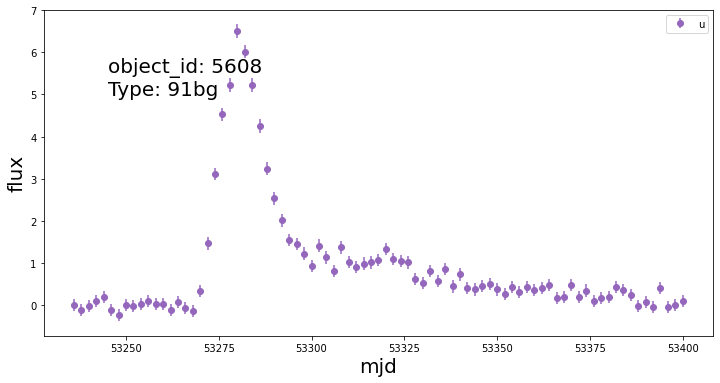

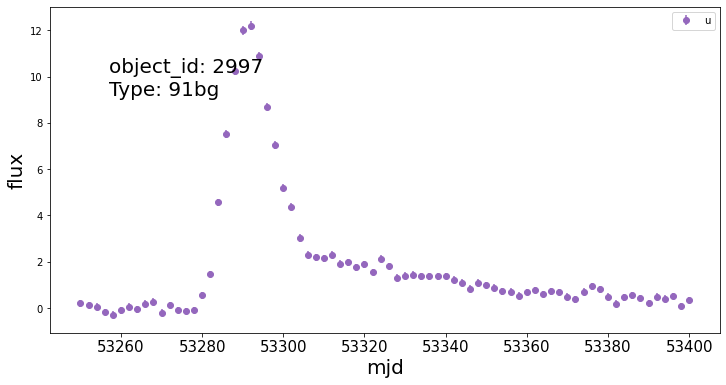

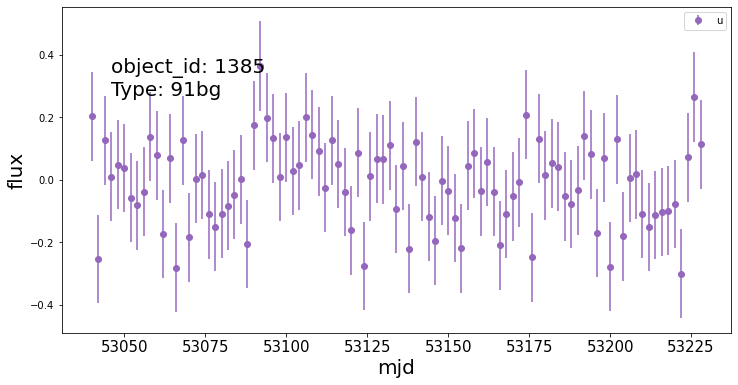

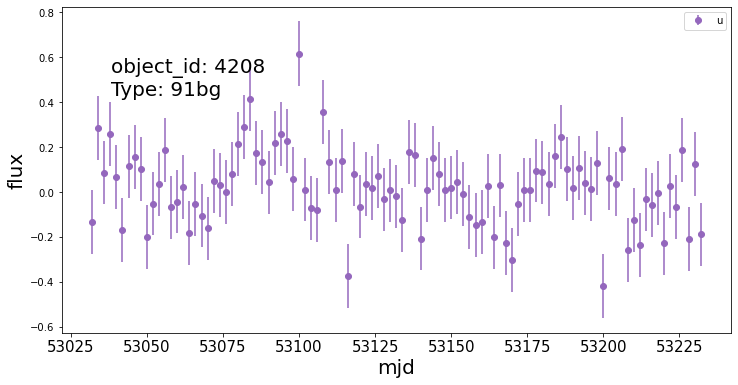

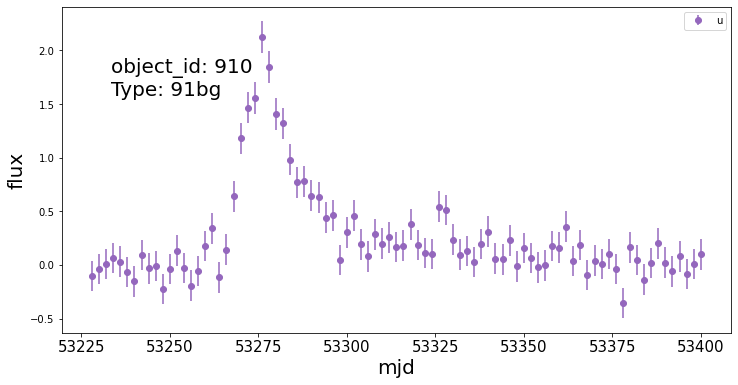

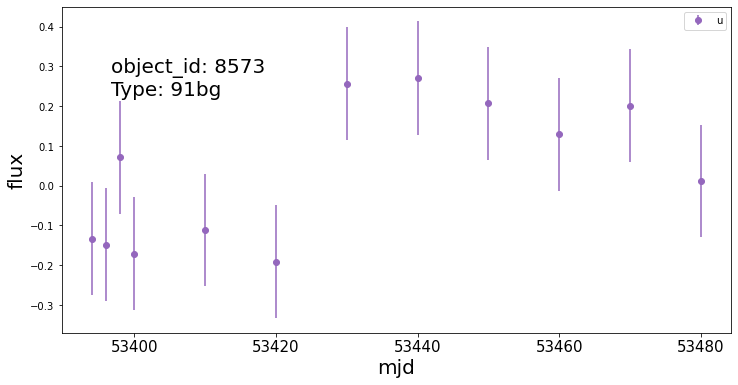

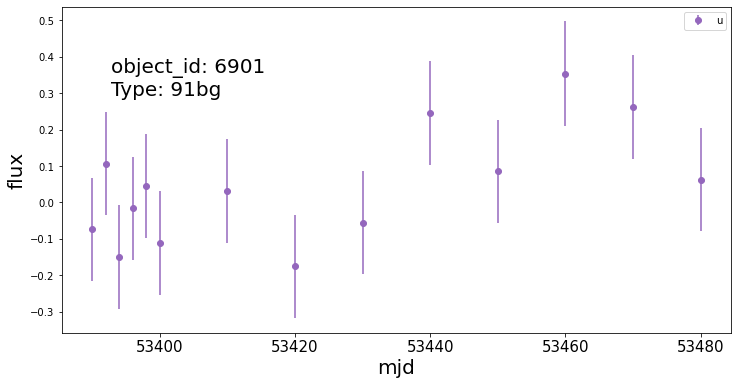

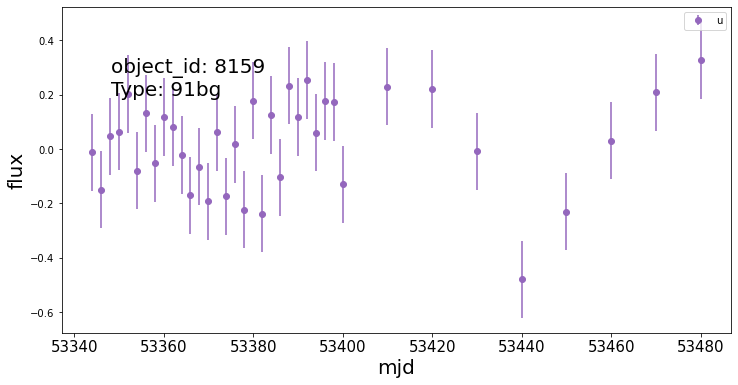

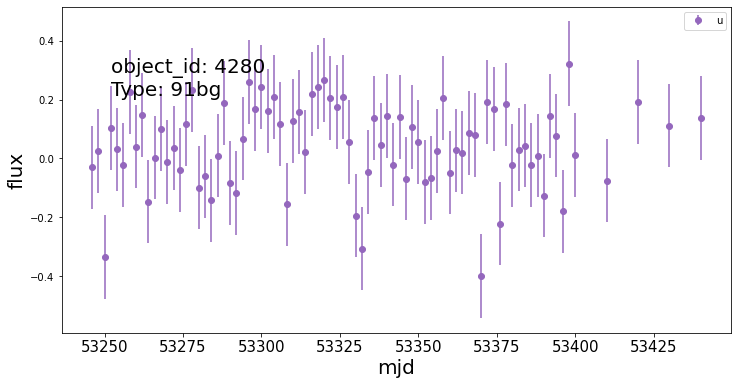

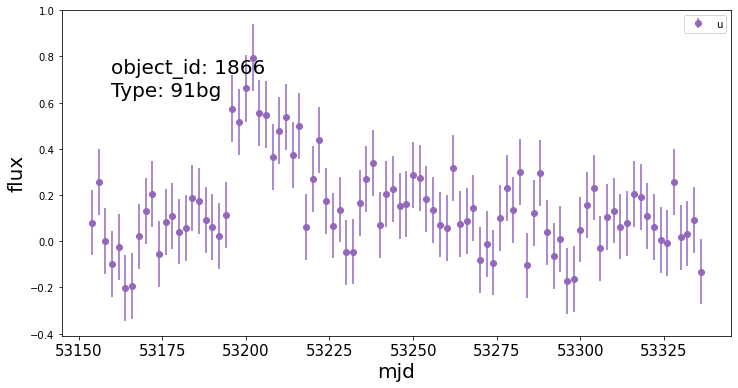

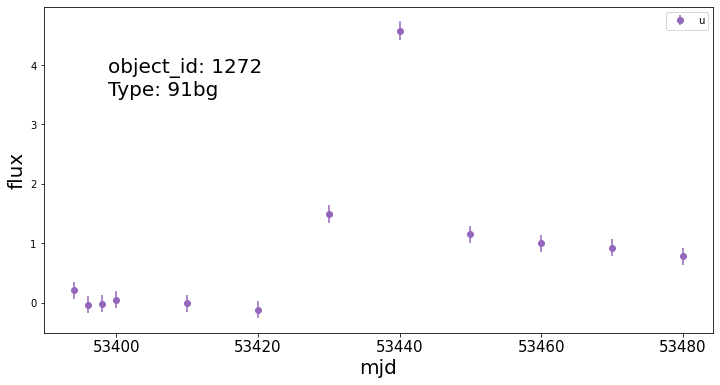

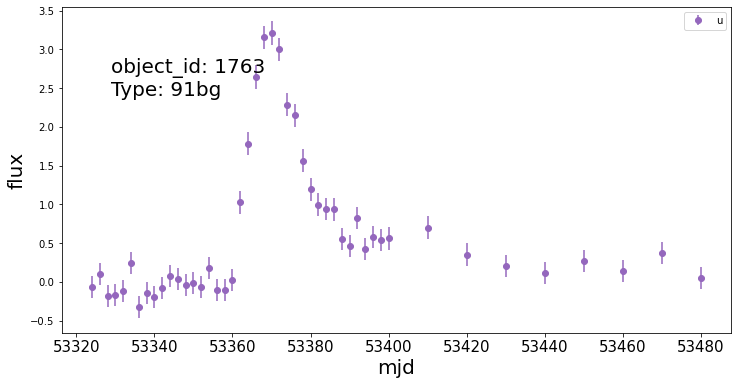

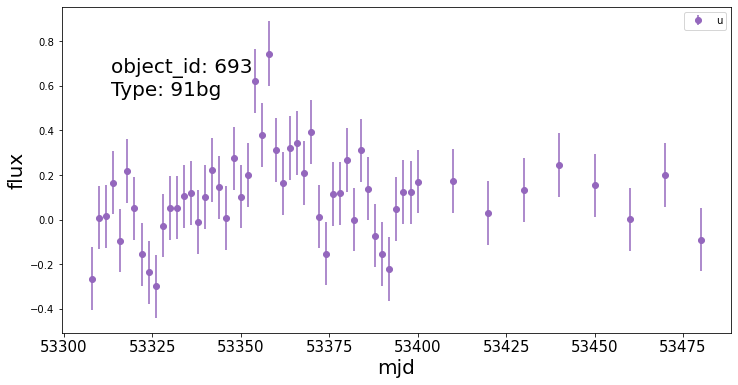

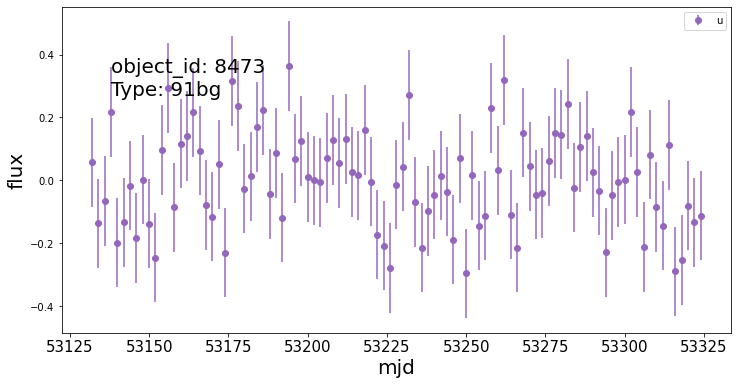

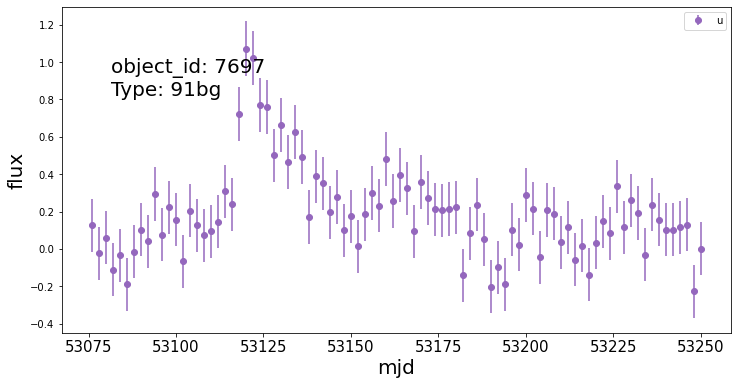

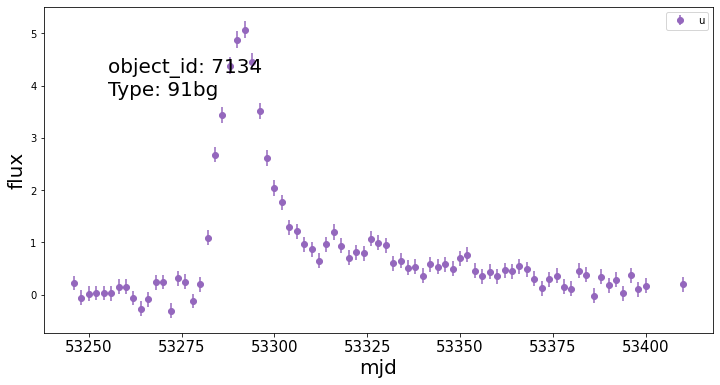

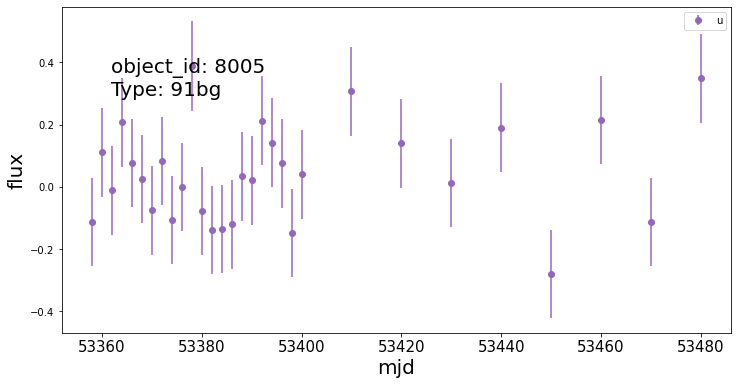

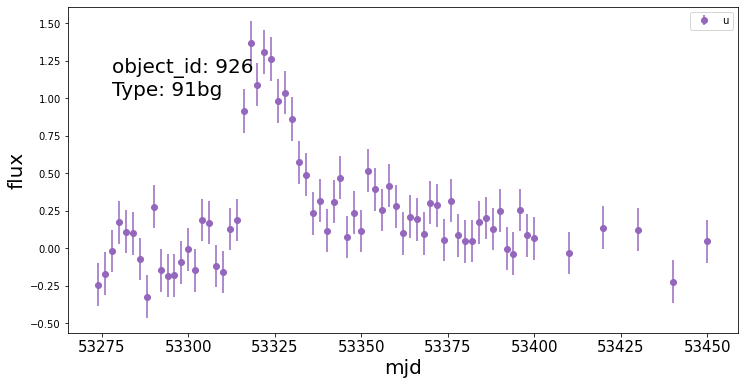

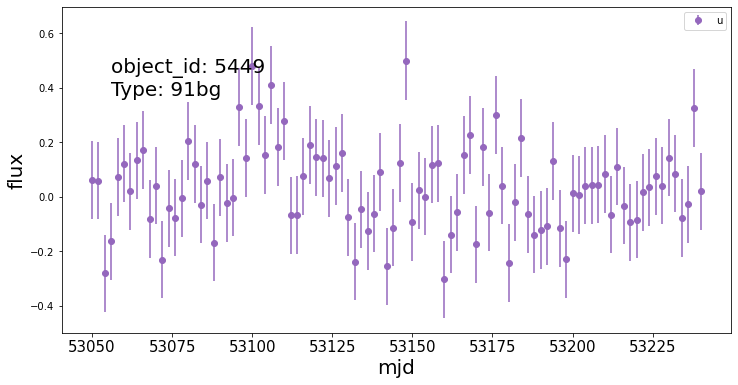

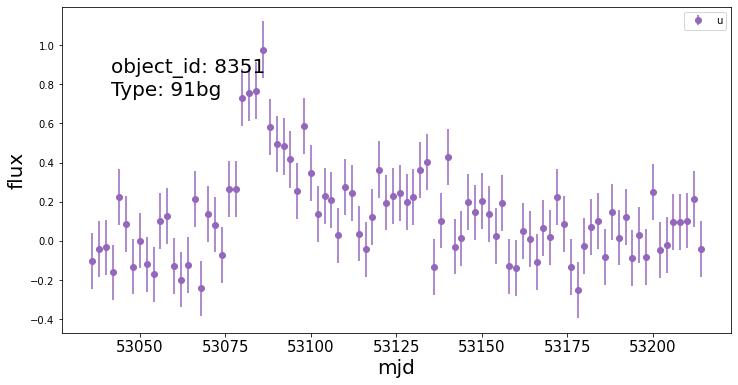

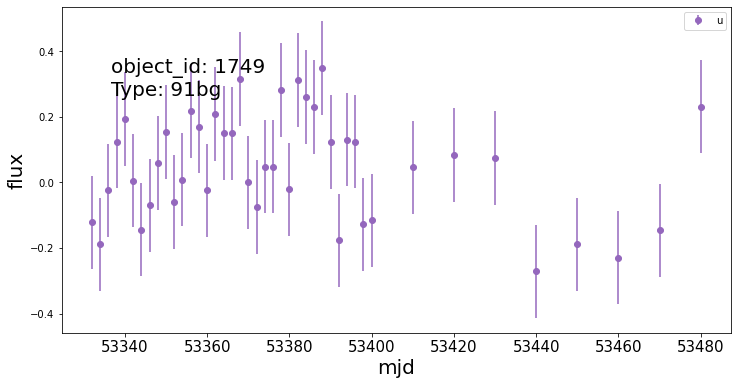

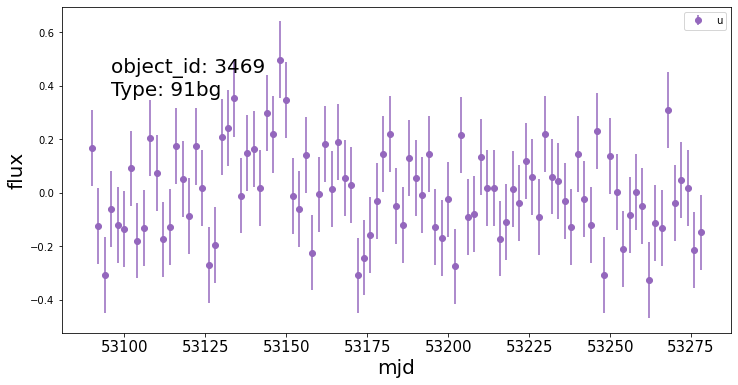

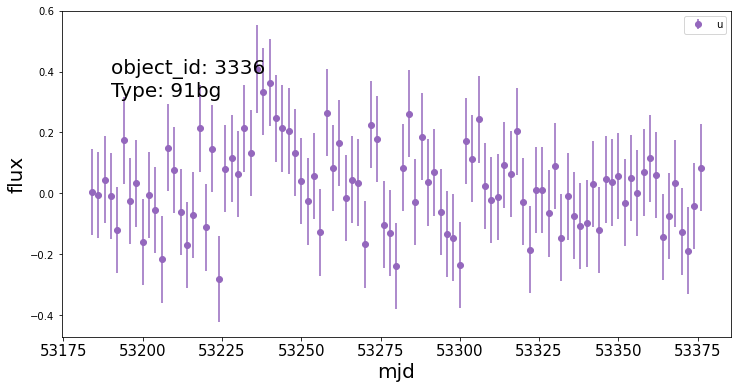

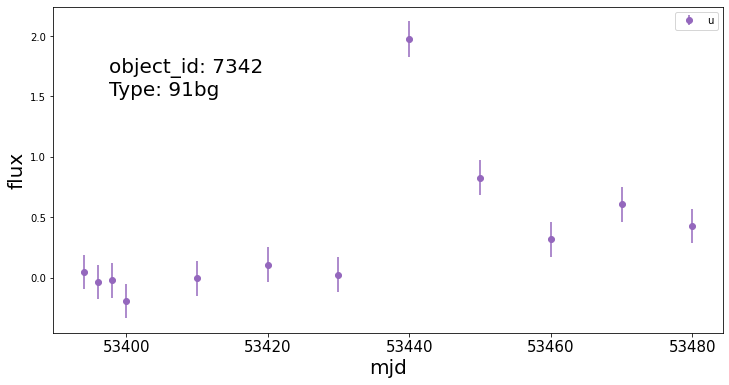

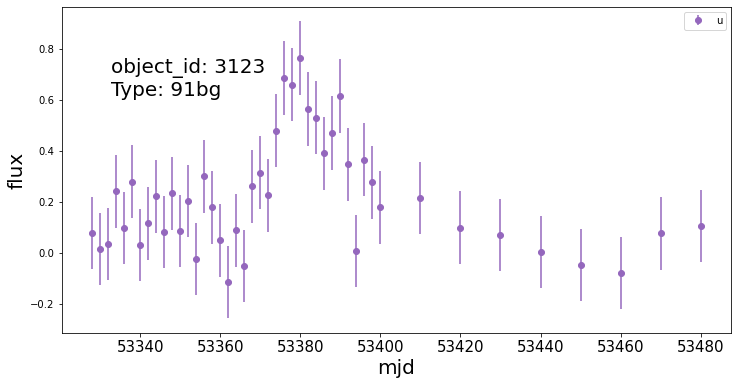

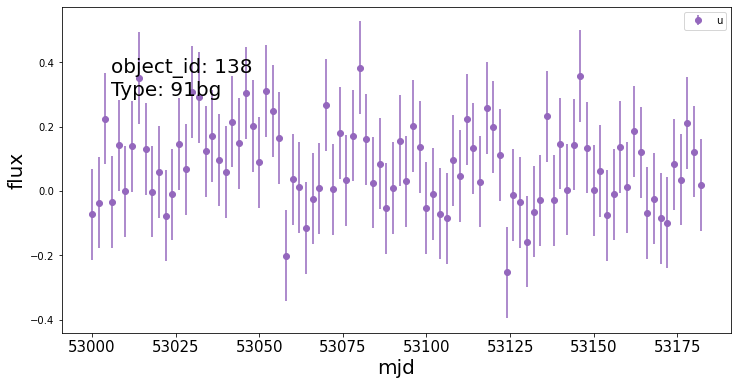

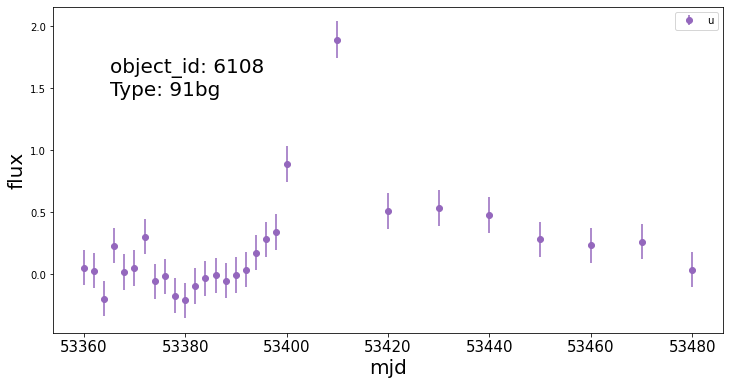

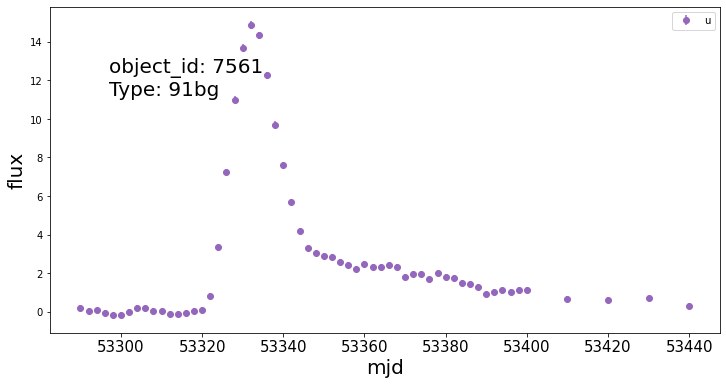

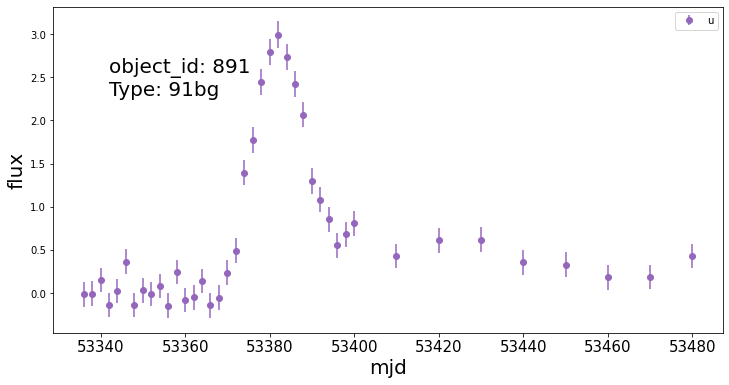

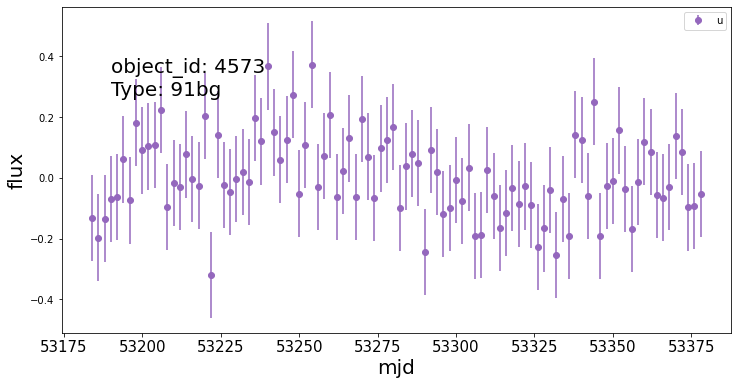

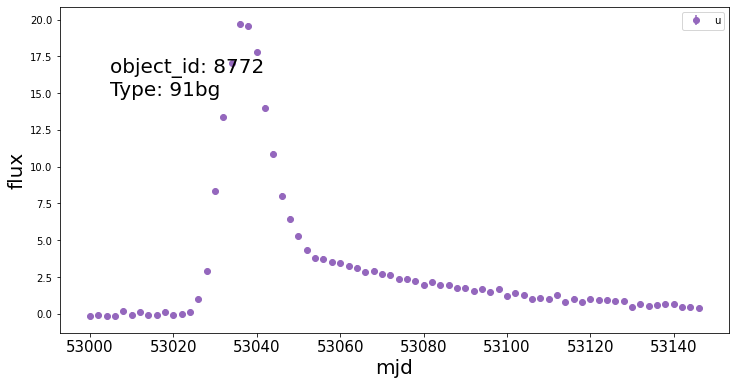

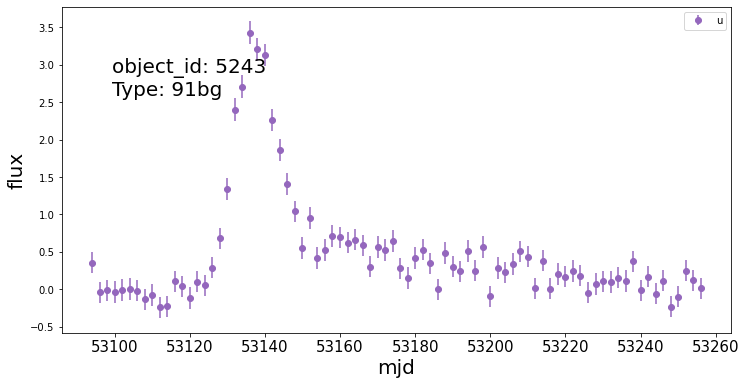

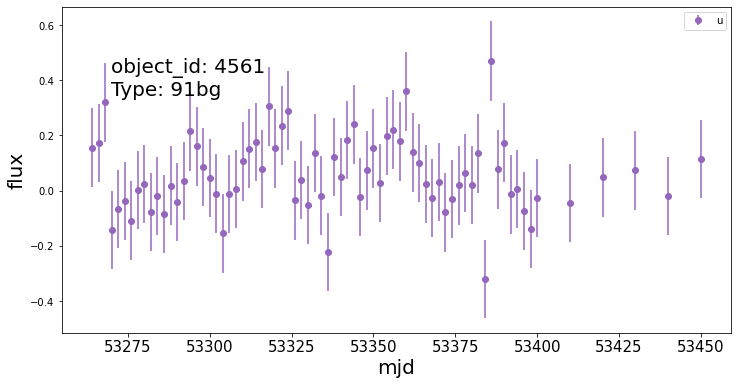

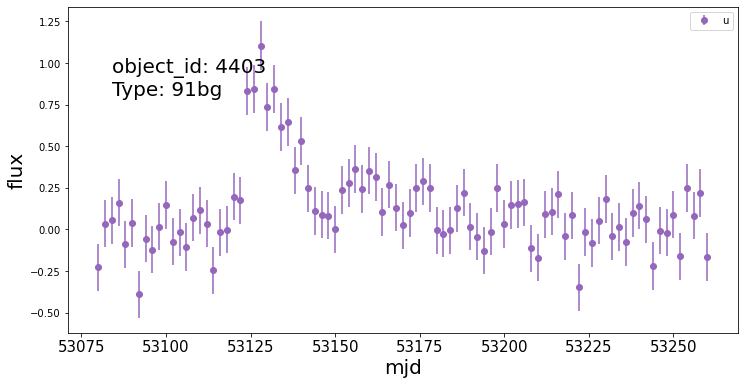

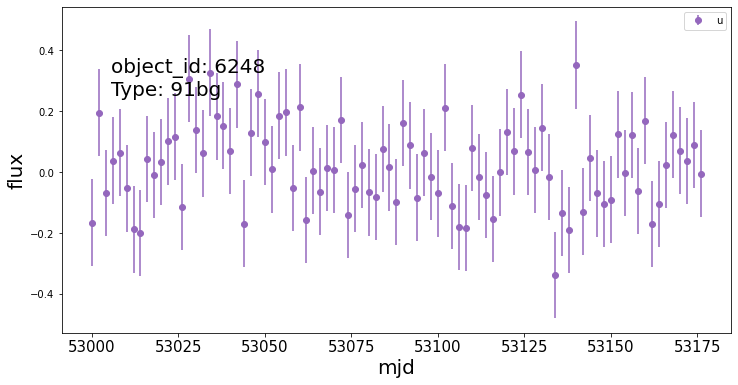

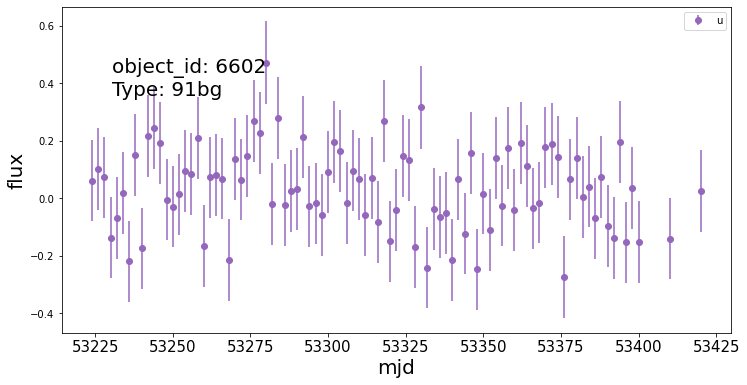

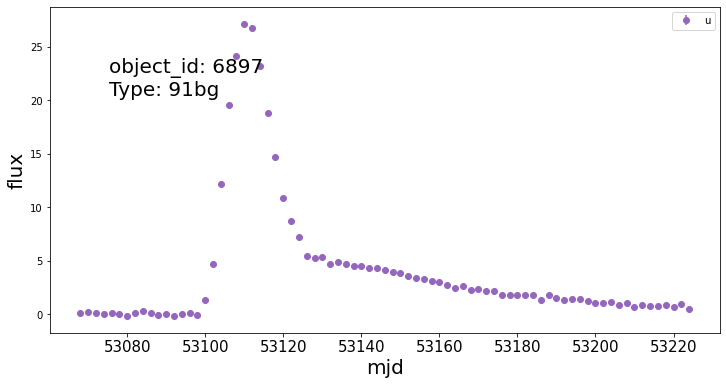

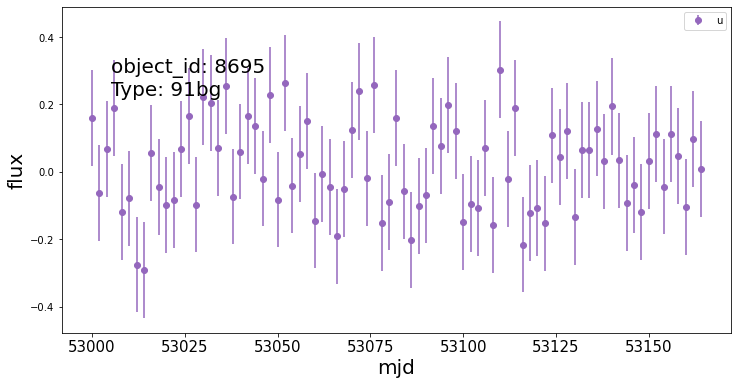

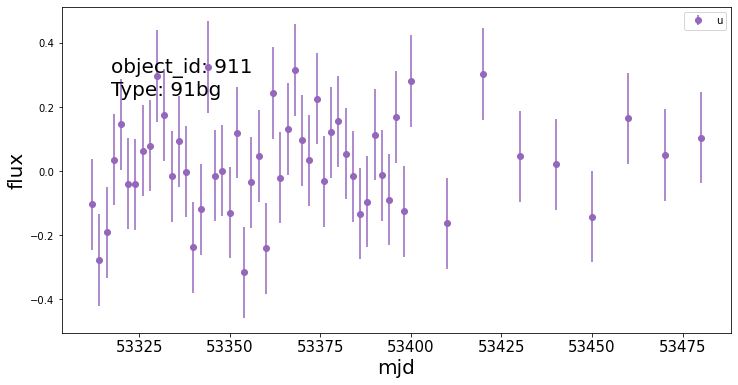

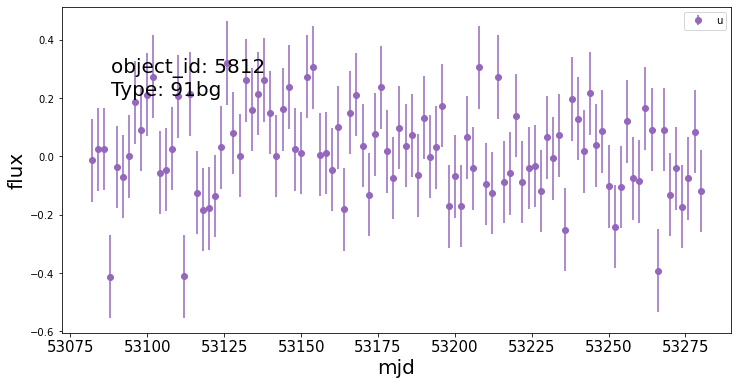

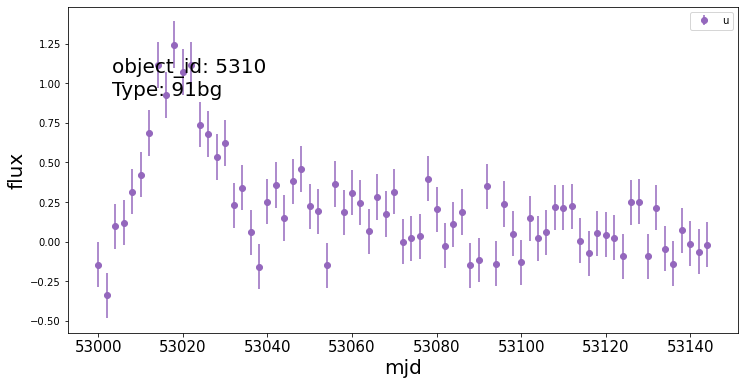

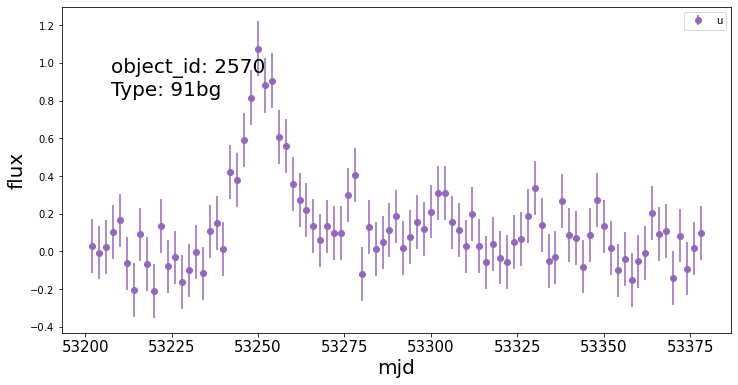

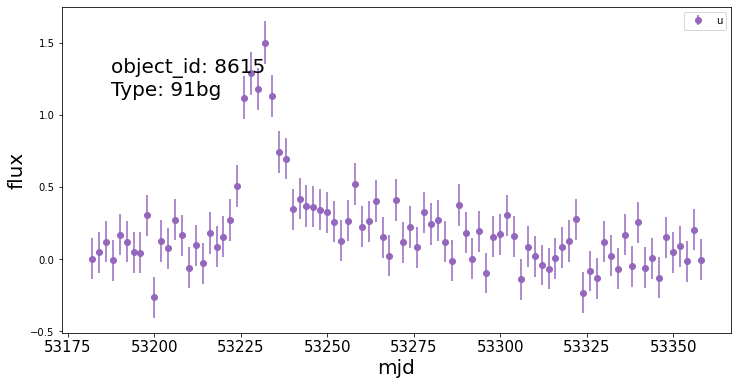

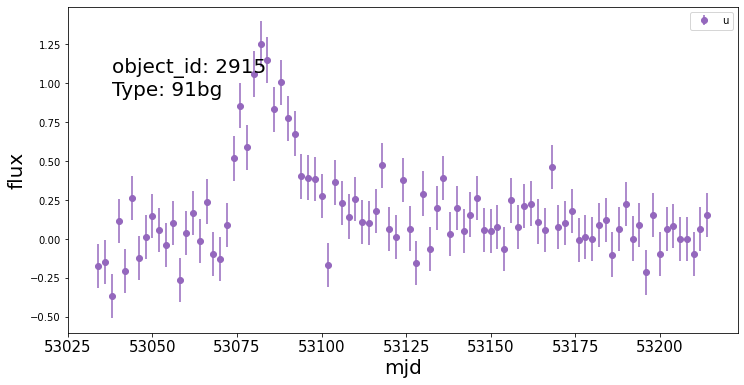

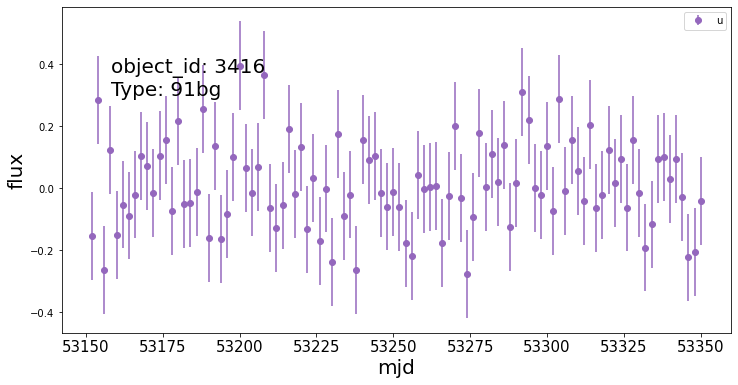

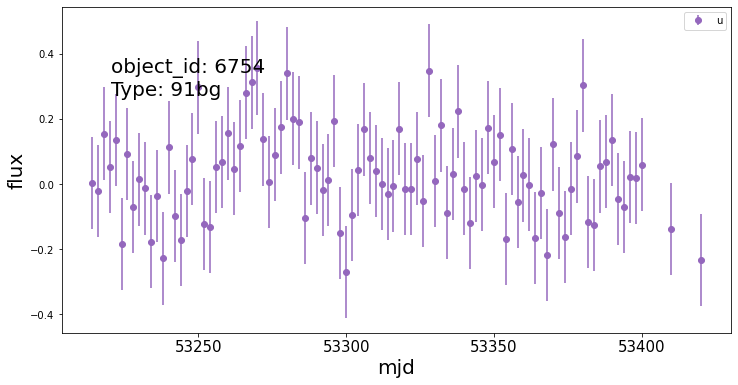

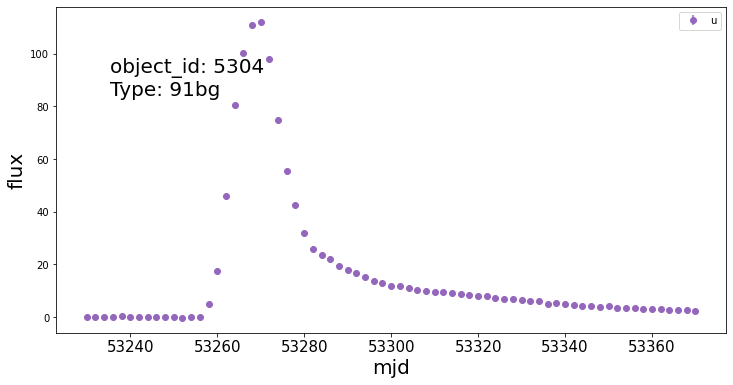

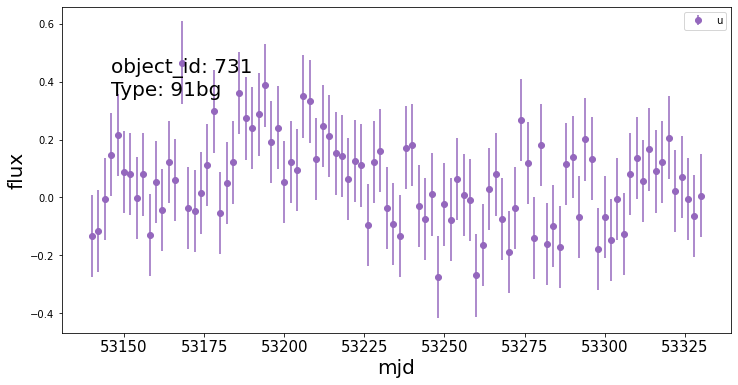

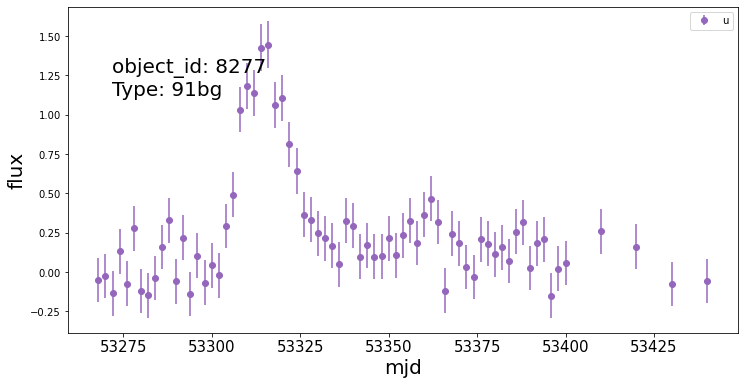

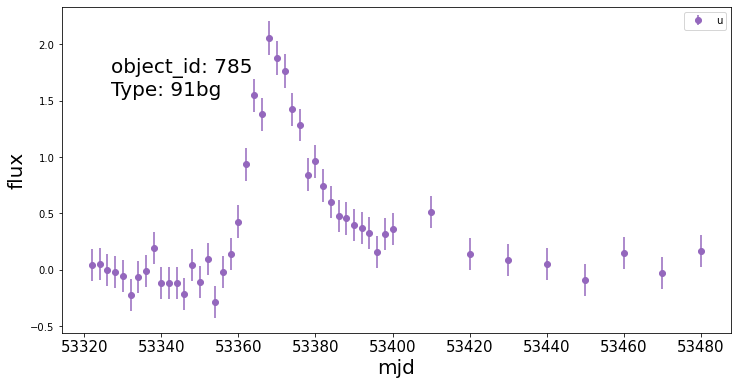

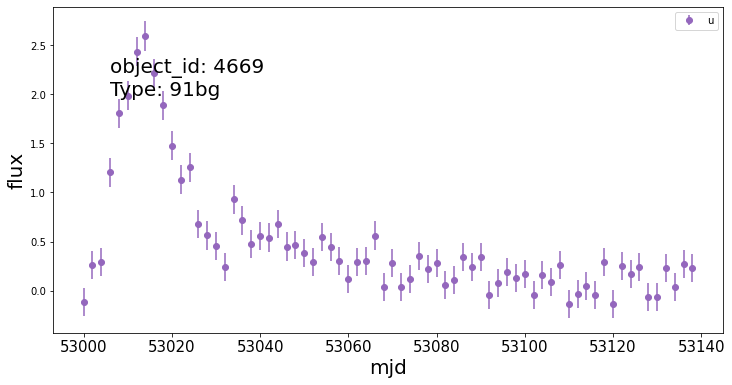

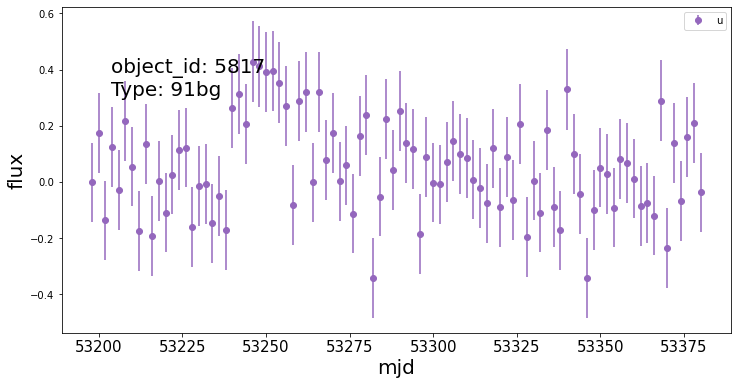

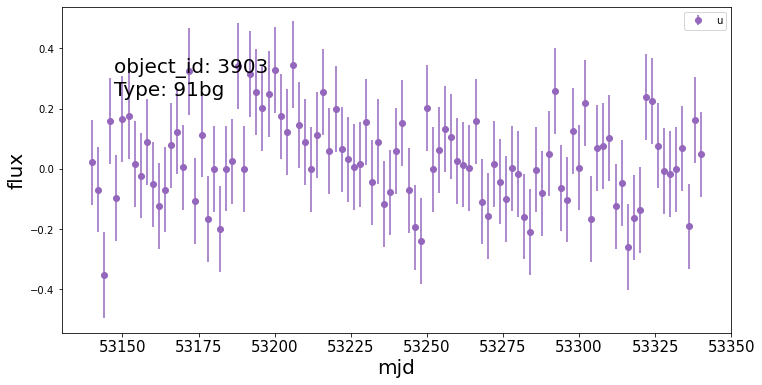

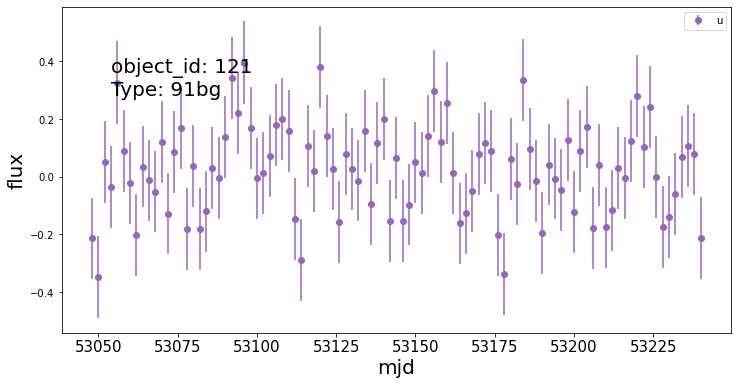

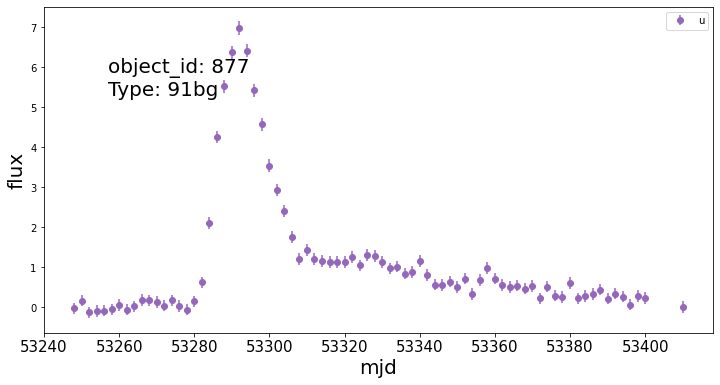

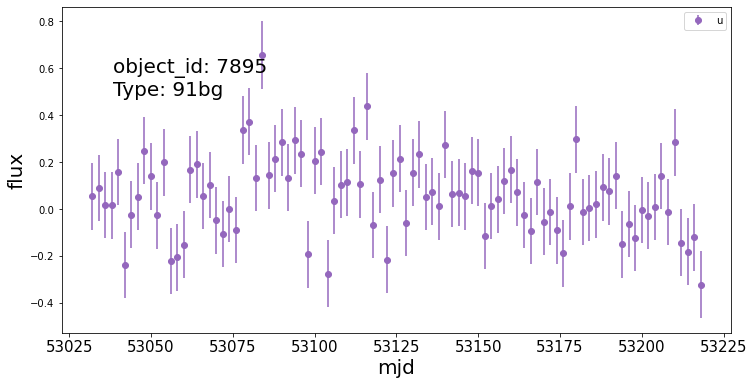

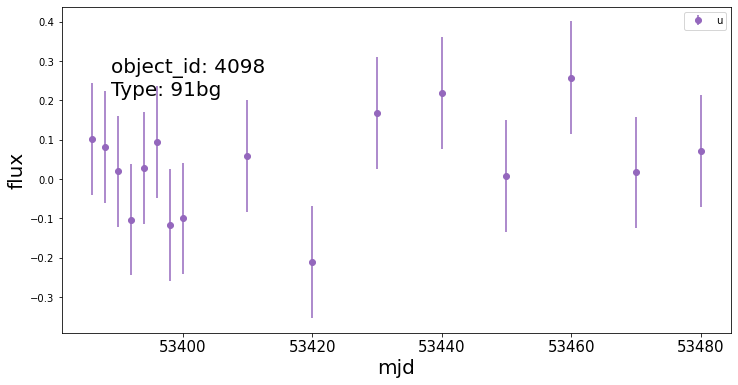

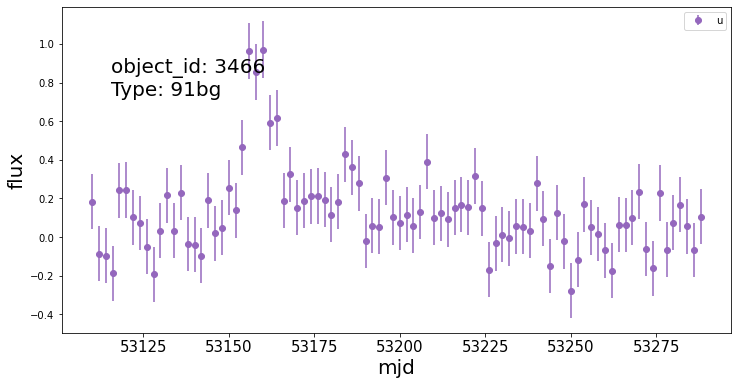

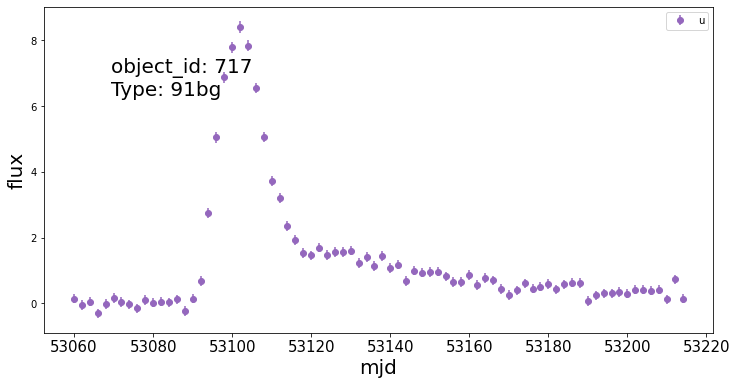

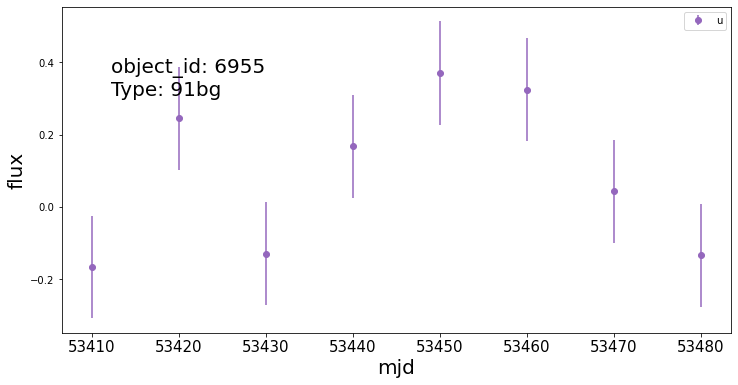

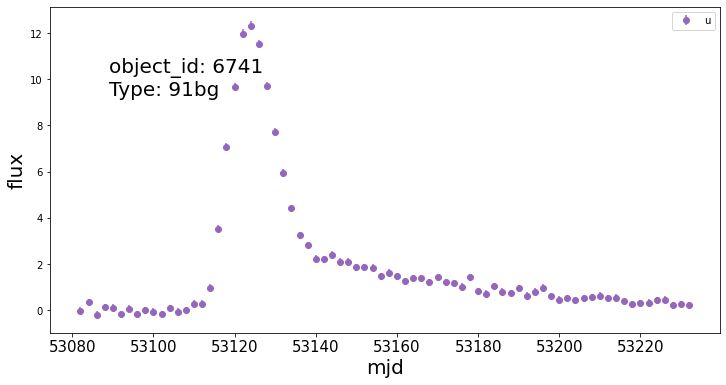

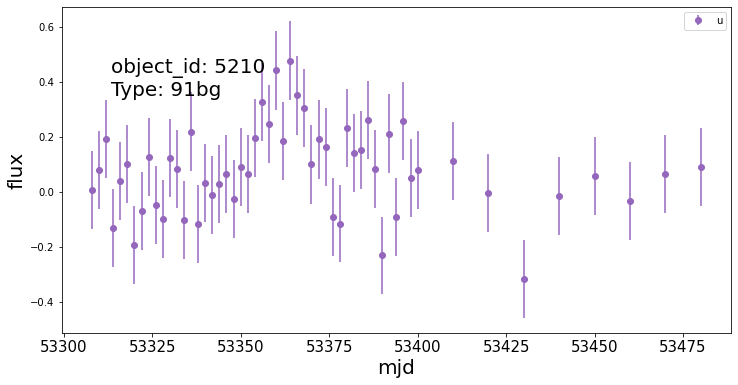

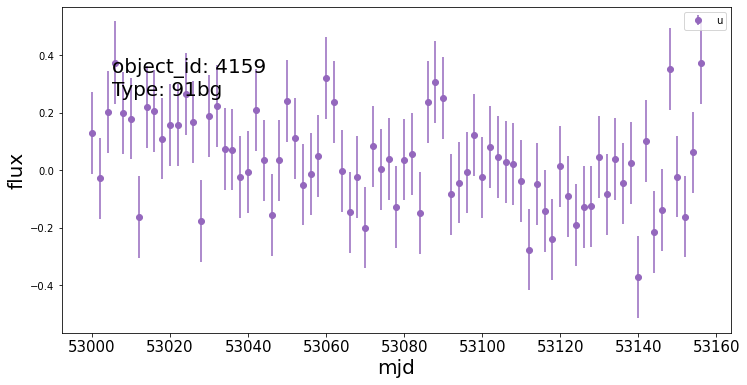

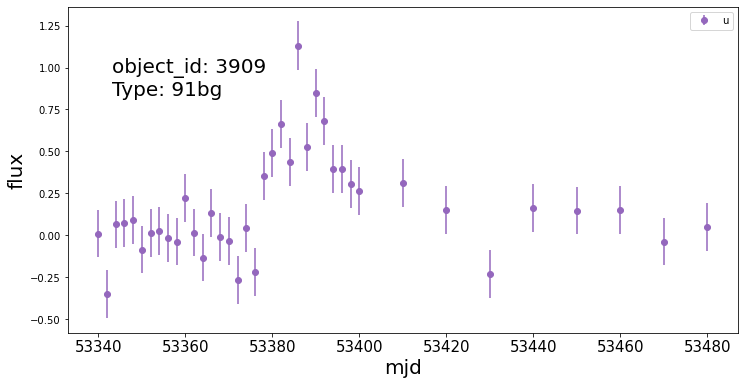

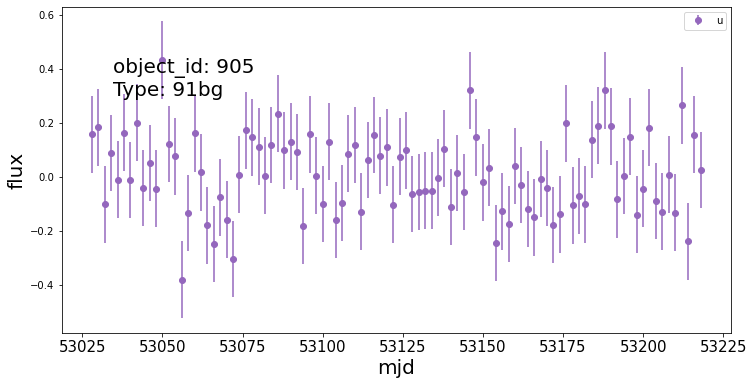

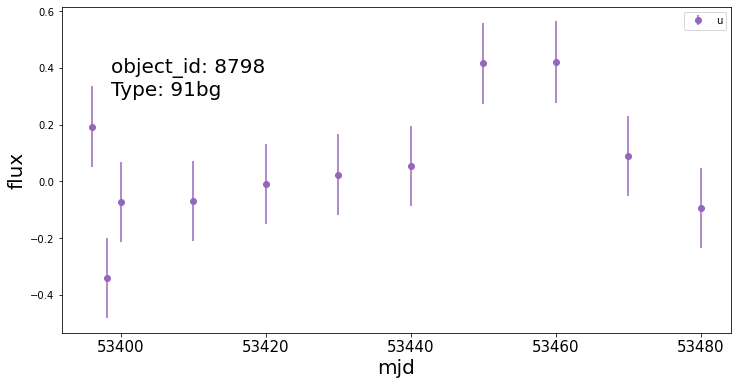

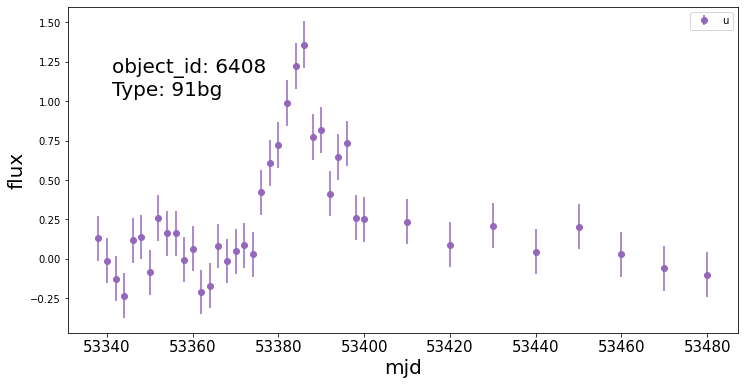

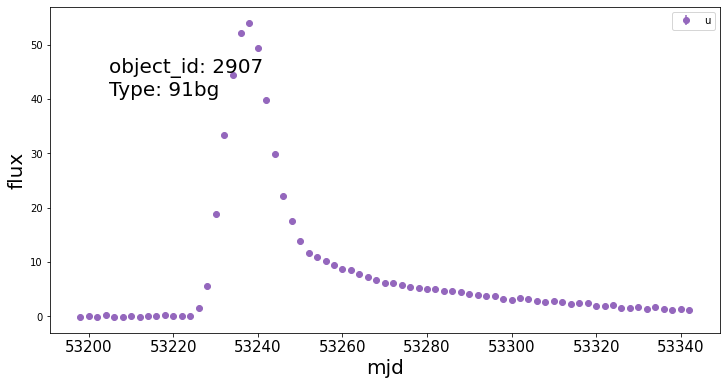

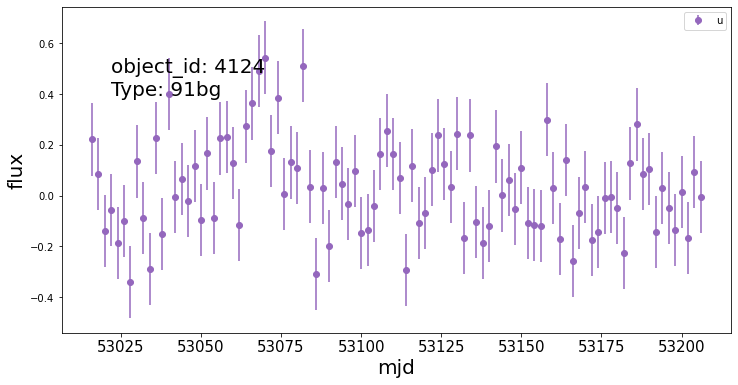

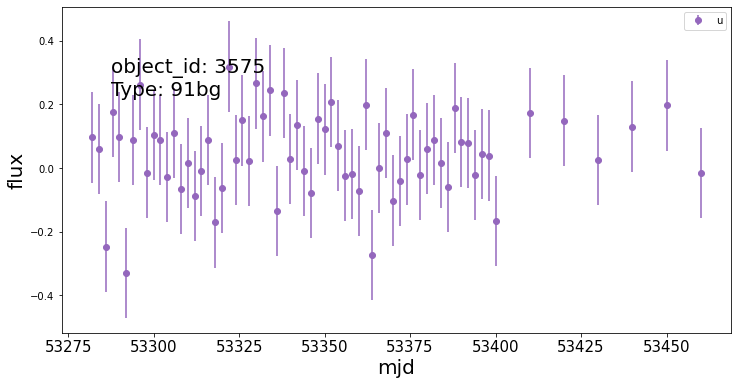

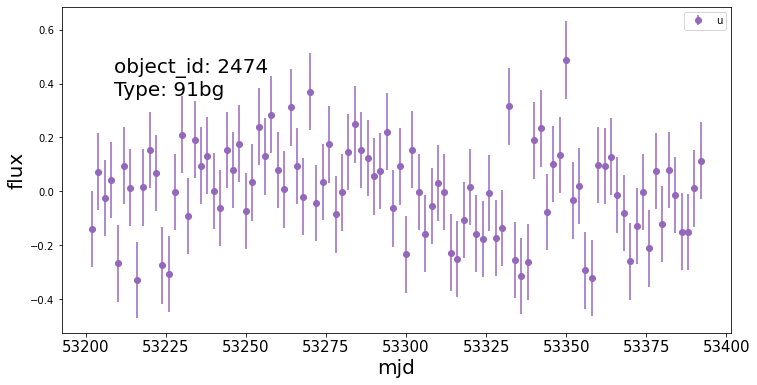

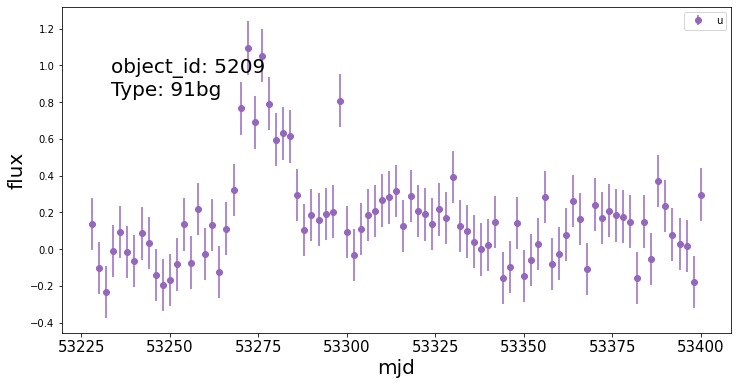

KeyboardInterrupt: 

<Figure size 864x432 with 0 Axes>

In [40]:
for object_id in object_ids:
    lc = LightCurve(data_ob=data_ob, object_id=object_id)
    fig = lc.plot_light_curve(color_band_dict=color_band_dict, band ='u', mark_label=True, mark_maximum= False,plot_points =True)
    type_name = data_ob.df_metadata['type'][data_ob.df_metadata[data_ob.object_id_col_name] == object_id][0]
    plt.gca().annotate("object_id: "+str(int(object_id)), xy = (.15,.81), xycoords='figure fraction', fontsize=20)
    plt.gca().annotate("Type: "+type_name, xy = (.15,.75), xycoords='figure fraction', fontsize=20)
    plt.rc('xtick', labelsize = 15)
    fig.savefig("Perfect_plots/raw/id_"+str(int(object_id))+"_uband")
    plt.legend()
    plt.show()
    plt.close('all')

In [41]:
object_ids = np.sort(object_ids)

In [42]:
object_ids

array([3.000e+00, 4.000e+00, 7.000e+00, ..., 8.957e+03, 8.965e+03,
       8.968e+03])

In [43]:
from LightCurve import LightCurve

In [44]:
number_of_days_in_lc = 100
time_step=2

In [45]:
def get_alert_mid_pt(event_df, bands, current_date=None):
    
    if current_date is not None:
        date_difference = event_df[data_ob.time_col_name] - current_date
        past_index = (date_difference>=-50) & (date_difference<=0)
        event_df = event_df[past_index]
    
    band_mid_points = []
    for i,band in enumerate(bands):
        band_index = event_df[data_ob.band_col_name] == band
        band_df = event_df[band_index]
        
        PCs = np.load("PCs.npy")
        PCs = PCs[0:3]
        initial_guess = [.93,.03 ,.025]
        #regularization_base = [.93,.04,.012]
        if(len(band_df)>0):
            max_index = np.argmax(band_df[data_ob.flux_col_name])
            band_mid_points.append(band_df[data_ob.time_col_name][max_index])
    if len(band_mid_points)>0:
        return np.median(np.array(band_mid_points))
    else:
        return None

In [46]:
def gen_all_band_same_maxpt_PCs():

    final_array = {}
    for pb_name in data_ob.band_map.keys():
        final_array[pb_name] = np.zeros((len(object_ids),51))

    for i,object_id in enumerate(object_ids):
        event_df = data_ob.get_data_of_event(object_id)
        mid_point = get_alert_mid_pt(event_df, data_ob.band_map.keys())
        print(mid_point)
        fig , ax = plt.figure((12,6))
        if mid_point is not None:

            start_date = mid_point-number_of_days_in_lc/2
            end_date = mid_point+number_of_days_in_lc/2

            start_index = event_df['MJD']>= start_date
            end_index = event_df['MJD'] <= end_date

            df_within_date = event_df[start_index*end_index]

            for band in data_ob.band_map.keys():

                band_df = df_within_date[df_within_date[data_ob.band_col_name] == band]

                if len(band_df)>0:

                    rand_int = 0

                    shifted_flux = np.zeros_like(band_df['FLUXCAL'])
                    len_flux = len(band_df['FLUXCAL'])

                    if (rand_int>0)&(len_flux>rand_int):
                        shifted_flux[rand_int:len_flux] = band_df['FLUXCAL'][0:len_flux-rand_int]

                    elif (rand_int<0)&(rand_int>-len_flux-1):
                        shifted_flux[0:len_flux+rand_int] = band_df['FLUXCAL'][-rand_int:len_flux]

                    elif (rand_int==0):
                        shifted_flux = band_df['FLUXCAL']

                    else:
                        continue



                    max_loc = int((mid_point-np.amin(band_df['MJD']))/2)
                    flux_data = np.zeros((51))
                    flux_data[25-max_loc:25-max_loc+len(band_df['MJD'])] = shifted_flux
                    final_array[band][i] = flux_data
                    ax.scatter(np.arange(0,102,2), flux_data,
                                color=color_band_dict[band], label=str(band))
        else: 
            continue

    return fig   
        
        
        

In [47]:
def gen_all_band_diff_maxpt_PCs():
    final_array = {}
    for pb_name in data_ob.band_map.keys():
        final_array[pb_name] = np.zeros((len(object_ids),51))
        
    for i,object_id in enumerate(object_ids):
        print(object_id)
        event_df = data_ob.get_data_of_event(object_id)
        
        fig = plt.figure(figsize=(12,6))
        ax = fig.add_subplot(1, 1, 1)
        for band in data_ob.band_map.keys():
            
            band_index = event_df[data_ob.band_col_name]==band
            band_df = event_df[band_index]
            
            if(len(band_df)>0):
                loc = np.argmax(band_df[data_ob.flux_col_name])
                mid_point = band_df[data_ob.time_col_name][loc]
                start_date = mid_point-number_of_days_in_lc/2
                end_date = mid_point+number_of_days_in_lc/2
                start_index = band_df['MJD']>= start_date
                end_index = band_df['MJD'] <= end_date


                band_df = band_df[start_index*end_index]
                if len(band_df)>0:
                    loc = np.argmax(band_df[data_ob.flux_col_name])
                    rand_int = int(random()*6)-3
                    #rand_int = 0

                    shifted_flux = np.zeros_like(band_df['FLUXCAL'])
                    len_flux = len(band_df['FLUXCAL'])

                    if (rand_int>0)&(len_flux>rand_int):
                        shifted_flux[rand_int:len_flux] = band_df['FLUXCAL'][0:len_flux-rand_int]

                    elif (rand_int<0)&(rand_int>-len_flux-1):
                        shifted_flux[0:len_flux+rand_int] = band_df['FLUXCAL'][-rand_int:len_flux]

                    elif (rand_int==0):
                        shifted_flux = band_df['FLUXCAL']

                    else:
                        continue

                    flux_data = np.zeros((51))
                    flux_data[25-loc:25-loc+len(band_df['MJD'])] = shifted_flux
                    final_array[band][i] = flux_data
                    x_data = np.arange(0,102,2)
                    print(np.argmax(flux_data))
                    if band == 'u':
                        ax.scatter(np.arange(0,102,2), flux_data, color=color_band_dict[band], label=band)
                    
                    
                    
                    
                    
        type_name = data_ob.df_metadata['type'][data_ob.df_metadata[data_ob.object_id_col_name] == object_id][0]
        #plt.gca().annotate("object_id: "+str(int(object_id)), xy = (.15,.81), xycoords='figure fraction', fontsize=20)
        #plt.gca().annotate("Type: "+type_name, xy = (.15,.75), xycoords='figure fraction', fontsize=20)
        #ax.axvline(x=50,ymin=0,ymax=1,label="Day 50",linestyle = "--")
        #plt.xlabel("Days", fontsize=20)
        #plt.ylabel("Flux", fontsize=20)
        #plt.rc("xtick", labelsize=15)
        #ax.legend()
        #fig.savefig("Perfect_plots/shifted/id_"+str(int(object_id))+"_uband")
        #plt.show()
        plt.close('all')

                    
    return final_array

In [48]:
object_ids = np.sort(object_ids)

In [49]:
print(object_ids)

[3.000e+00 4.000e+00 7.000e+00 ... 8.957e+03 8.965e+03 8.968e+03]


In [51]:
final_array = gen_all_band_diff_maxpt_PCs()
#plt.show()
plt.close('all')
#print(final_array.keys())

3.0
27
25
23
27
22
22
4.0
23
27
22
25
22
22
7.0
23
25
22
26
27
26
36.0
22
23
27
25
26
24
42.0
27
23
22
25
22
25
44.0
24
22
26
24
24
26
48.0
22
26
27
24
22
24
51.0
24
26
25
24
23
27
57.0
27
23
26
25
26
24
58.0
23
26
22
23
22
27
66.0
22
27
23
22
27
26
69.0
26
25
26
22
22
22
70.0
26
22
22
26
27
23
88.0
23
23
25
27
27
25
89.0
24
25
25
25
26
25
92.0
27
25
25
27
26
24
98.0
22
27
23
22
22
26
102.0
23
26
25
26
24
25
109.0
26
23
25
26
27
27
121.0
26
27
27
25
23
24
130.0
22
27
24
24
25
24
131.0
24
22
24
23
25
23
133.0
27
24
24
23
27
24
138.0
27
23
24
23
24
22
145.0
24
24
24
23
25
26
158.0
24
25
24
24
24
25
160.0
22
22
26
27
25
24
169.0
23
27
25
27
22
23
181.0
26
27
24
26
26
26
194.0
22
27
24
27
24
23
204.0
22
25
24
24
25
25
211.0
23
26
22
24
22
25
219.0
23
27
23
24
27
23
224.0
23
26
27
24
23
23
230.0
23
24
23
26
27
26
232.0
25
25
23
27
25
26
235.0
22
23
25
26
24
25
237.0
22
22
22
23
23
27
240.0
27
26
25
22
27
22
250.0
23
26
26
26
22
27
254.0
26
24
27
26
23
24
256.0
27
25
23
23
24
27
261.0
24
22


26
22
26
26
24
1924.0
26
26
26
23
23
26
1936.0
26
27
24
23
23
27
1937.0
25
27
23
23
26
27
1942.0
23
23
25
26
26
24
1944.0
26
26
25
24
27
25
1947.0
24
27
26
26
26
27
1958.0
23
22
26
24
22
24
1968.0
25
26
26
27
23
22
1972.0
25
26
26
24
24
26
1981.0
27
26
24
26
23
25
1982.0
25
26
22
22
27
26
1990.0
27
24
22
25
22
24
1992.0
27
26
24
22
22
25
1996.0
23
22
26
27
27
23
2002.0
27
25
23
23
24
25
2017.0
25
23
25
24
25
27
2034.0
24
25
22
24
24
23
2041.0
27
24
26
22
25
25
2043.0
27
25
22
27
22
23
2046.0
22
25
24
23
26
23
2062.0
23
24
22
26
27
22
2063.0
23
23
24
23
27
26
2074.0
27
25
23
26
25
24
2075.0
23
23
25
23
26
27
2076.0
24
22
25
22
25
24
2080.0
23
25
27
23
27
23
2087.0
24
26
23
27
25
24
2094.0
24
23
25
27
22
23
2106.0
26
22
23
23
27
26
2109.0
26
24
23
24
22
24
2115.0
25
23
27
27
25
25
2125.0
22
26
27
26
25
25
2127.0
24
24
27
23
27
23
2130.0
22
24
27
24
24
26
2132.0
24
25
26
24
27
22
2133.0
26
26
27
25
27
22
2136.0
24
22
22
22
25
23
2139.0
22
24
23
26
27
23
2151.0
22
26
27
24
27
26
2157.0
26


26
23
27
26
27
23
3833.0
23
22
22
25
25
27
3842.0
22
24
24
26
27
22
3844.0
22
23
27
25
26
25
3847.0
24
25
26
22
25
22
3851.0
24
25
24
25
24
26
3867.0
24
22
24
26
25
26
3889.0
23
22
27
24
26
25
3892.0
24
23
22
23
26
26
3895.0
27
22
23
24
23
22
3897.0
23
27
23
24
23
26
3898.0
24
24
23
24
24
22
3903.0
27
24
22
24
25
27
3909.0
25
27
24
25
27
26
3910.0
22
27
24
26
24
27
3920.0
27
23
24
24
27
22
3930.0
23
22
26
23
24
26
3932.0
25
23
27
27
23
23
3943.0
24
22
27
22
26
25
3948.0
25
25
22
26
23
24
3951.0
23
24
27
27
26
22
3953.0
22
27
22
24
25
24
3964.0
22
24
25
22
27
25
3966.0
22
23
23
26
25
24
3973.0
22
24
25
24
25
26
3978.0
27
23
23
27
25
24
3988.0
24
25
27
22
22
27
3989.0
22
27
26
27
25
26
3992.0
26
23
22
22
23
23
4016.0
25
24
25
24
23
22
4017.0
25
22
22
23
27
24
4021.0
25
25
27
23
24
26
4036.0
26
25
22
22
25
22
4037.0
27
24
27
25
26
27
4044.0
27
23
27
27
27
27
4050.0
25
26
23
24
23
26
4051.0
24
25
27
27
26
25
4061.0
25
23
22
22
27
23
4071.0
27
25
24
24
22
25
4082.0
26
26
25
23
24
24
4085.0


27
23
23
23
23
26
5640.0
26
24
26
27
25
25
5641.0
27
25
22
22
26
24
5642.0
23
25
27
25
24
22
5646.0
24
27
22
22
23
24
5650.0
24
23
23
27
23
23
5651.0
23
27
26
26
26
27
5663.0
26
27
25
23
23
27
5678.0
26
27
22
25
26
22
5683.0
25
26
25
26
27
26
5688.0
22
22
27
26
22
26
5692.0
25
25
25
23
22
24
5694.0
27
22
23
26
22
26
5698.0
24
23
22
26
27
27
5700.0
22
23
22
23
27
22
5706.0
22
25
27
23
22
24
5713.0
27
26
24
27
26
26
5716.0
22
26
25
25
26
25
5720.0
26
27
27
27
23
25
5735.0
26
23
27
25
23
26
5740.0
25
25
26
26
26
26
5741.0
27
24
22
23
23
26
5742.0
25
24
24
23
27
22
5747.0
23
25
26
22
24
25
5755.0
24
24
23
27
26
23
5765.0
25
24
24
25
26
26
5767.0
27
27
24
25
23
22
5772.0
27
24
23
22
25
25
5786.0
22
23
24
24
23
25
5789.0
22
22
25
23
22
24
5797.0
27
25
25
24
27
26
5798.0
22
24
26
27
27
27
5799.0
25
23
22
23
25
24
5804.0
26
24
22
26
26
26
5807.0
26
26
27
26
26
22
5808.0
23
24
27
22
22
27
5812.0
22
27
22
24
25
27
5815.0
27
24
22
22
27
24
5817.0
26
27
24
24
23
27
5819.0
25
23
24
26
24
24
5822.0


26
27
27
26
23
25
7488.0
25
24
23
23
23
26
7490.0
27
22
23
23
26
25
7497.0
25
24
22
23
23
23
7500.0
26
24
27
24
23
23
7505.0
22
25
22
27
26
26
7508.0
22
26
23
24
26
23
7518.0
22
22
23
24
23
25
7522.0
25
23
22
23
25
24
7524.0
27
24
22
26
23
27
7545.0
26
27
25
25
25
25
7546.0
26
27
22
25
27
27
7553.0
25
26
24
24
27
22
7554.0
26
22
27
23
25
27
7558.0
27
24
24
24
25
26
7561.0
23
22
23
22
22
24
7565.0
22
22
22
27
22
22
7566.0
23
27
22
22
22
27
7572.0
26
26
25
23
22
24
7579.0
23
27
22
26
22
26
7583.0
26
25
26
22
27
22
7586.0
24
23
22
27
23
26
7588.0
24
27
25
22
23
25
7591.0
27
23
22
23
22
25
7598.0
26
24
26
25
23
26
7602.0
27
24
25
22
27
22
7606.0
27
26
22
22
27
23
7608.0
27
27
22
26
24
27
7610.0
26
27
23
23
26
27
7613.0
24
22
23
25
23
27
7616.0
25
25
26
26
25
26
7617.0
25
23
24
27
22
22
7623.0
22
26
23
23
23
26
7624.0
24
23
25
26
22
23
7631.0
26
27
27
27
25
23
7635.0
25
22
26
24
25
23
7645.0
23
23
27
24
24
26
7647.0
24
26
22
26
25
24
7654.0
22
27
23
26
22
24
7666.0
26
22
23
24
24
23
7673.0


In [52]:
color_band_dict['u']

'C4'

In [53]:
final_array

{'u': array([[ 0.        ,  0.        ,  0.        , ...,  0.60934246,
          0.40715444,  0.02456525],
        [-0.2795264 ,  0.08817074, -0.09831816, ...,  0.3057622 ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.11700895,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.20269029,  0.0635633 ,  0.04849295, ...,  0.65721697,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]),
 'g': array([[0.        , 0.        , 0.        , ..., 2.8973496 , 2.7375019 ,
         2.2032764 ],
        [0.        , 0.        , 0.19068633, ..., 4.38342   , 3.7581894 ,
         3.3497796 ],
        [0.        , 0.        , 0.        , ..., 1.5897132 , 1.614819  ,
         1.7559097 ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 

In [54]:
def gen_PC_diff_bands():
    PC_dict = {}
    for pb_name in data_ob.band_map.keys():
        pca = PCA(n_components=10)
        fit_arr = final_array[pb_name]
        fit_arr[fit_arr<0] = 0 
        pca.fit(fit_arr)
        PC_dict[pb_name] = pca.components_
        #print(pca.explained_variance_ratio_)
        print(PC_dict[pb_name].shape)
    return pca, PC_dict

In [55]:
final_arr<0

NameError: name 'final_arr' is not defined

In [56]:
def gen_PC_mixed_bands():
    PC_dict = {}
    final_arr = []
    for pb_name in data_ob.band_map.keys():
        final_arr.extend(final_array[pb_name])
    #pca = PCA(n_components=10)
    final_arr = np.array(final_arr)
    print(final_arr[final_arr<0])
    final_arr[final_arr<0] = 0 
    pca = NMF(n_components =10)

    pca.fit(final_arr)
    PC_dict['all'] = pca.components_
    #print(pca.explained_variance_ratio_)
    return pca, PC_dict

In [57]:
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF

In [58]:
def gen_components(bands_combined = 0, method = 'NMF'):
    '''
    bool bands_combined: consider data of all bands together/individually
    string method: 'PCA'/'NMF'
    '''
    PC_dict = {}
    if method == 'PCA':
        clf = PCA(n_components =10)
    elif method == 'NMF':
        clf = NMF(n_components =10)
    if bands_combined == 0:
        for pb_name in data_ob.band_map.keys():
            fit_arr = final_array[pb_name]
            if method == 'NMF':
                fit_arr[fit_arr<0] = 0 
            clf.fit(fit_arr)
            PC_dict[pb_name] = clf.components_
            #print(pca.explained_variance_ratio_)
            print(PC_dict[pb_name].shape)
        return pca, PC_dict
    
    else:
        final_arr = []
        for pb_name in data_ob.band_map.keys():
            final_arr.extend(final_array[pb_name])
        #pca = PCA(n_components=10)
        final_arr = np.array(final_arr)
        #print(final_arr[final_arr<0])
        if method == 'NMF':
            final_arr[final_arr<0] = 0 
        clf.fit(final_arr)
        PC_dict['all'] = clf.components_
        #print(pca.explained_variance_ratio_)
        return clf, PC_dict
        

/home/biswajit/anaconda3/envs/kilonova/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


(10, 51)


/home/biswajit/anaconda3/envs/kilonova/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


(10, 51)


/home/biswajit/anaconda3/envs/kilonova/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


(10, 51)


/home/biswajit/anaconda3/envs/kilonova/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


(10, 51)


/home/biswajit/anaconda3/envs/kilonova/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


(10, 51)
(10, 51)


/home/biswajit/anaconda3/envs/kilonova/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


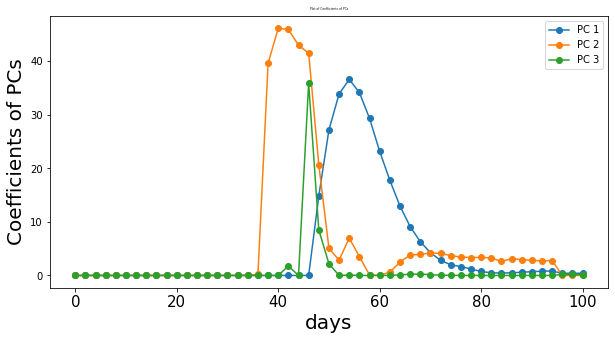

In [62]:
pca, PC_dict = gen_components(bands_combined = 1)
band = 'u'
PCs= PC_dict[band]
fig = plt.figure(figsize=(10,5))
for i in range(3):
    PC = PCs[i]
    x = np.arange(0,102,2)
    plt.plot(x,PC,marker='o',label = "PC "+str(i+1))

plt.xlabel("days", fontsize = 20)
plt.ylabel("Coefficients of PCs", fontsize=20)
#print(band)
plt.legend()
plt.title("Plot of Coefficients of PCs",fontsize=3)
#fig.savefig("Plot of PCs")
plt.show()

In [60]:
print(PC_dict.keys())

dict_keys(['all'])


In [ ]:
data_ob.band_map.keys()

In [ ]:
for band in data_ob.band_map.keys():
    print(band)
    PCs= PC_dict[band]
    fig = plt.figure(figsize=(10,5))
    for i in range(3):
        PC = PCs[i]
        x = np.arange(0,102,2)
        plt.plot(x,PC,marker='o',label = "PC "+str(i+1))

    plt.xlabel("days", fontsize = 20)
    plt.ylabel("Coefficients of PCs", fontsize=20)
    print(band)
    plt.legend()
    plt.title("Plot of Coefficients of PCs",fontsize=3)
    #fig.savefig("Plot of PCs")
    plt.show()

In [35]:
np.save('principal_components/NNMF_all_bands_mixed_dict', PC_dict)

In [58]:
print(PC_dict['u'][0:3])

KeyError: 'u'

In [59]:
for object_id in object_ids:
    event_df = data_ob.get_data_of_event(object_id)
    lc = LightCurve(data_ob.get_data_of_event(object_id), time_col_name=data_ob.time_col_name, brightness_col_name=data_ob.flux_col_name, brightness_err_col_name=data_ob.flux_err_col_name,band_col_name=data_ob.band_col_name, band_map=data_ob.band_map)
    fig = lc.plot_light_curve(color_band_dict, alpha = 1)
    plt.show()
    plt.close('all')
    
    

TypeError: __init__() got an unexpected keyword argument 'time_col_name'

In [ ]:
num_of_elements=51
final_array = np.zeros((len(object_ids),num_of_elements))

for j in range(10):
    
    for i,object_id in enumerate(objects_ids):
        #print(i)
        ob_list = []
        object_mask = df['SNID']==object_id
        object_df = df[object_mask]


        #for band in filters.keys():

        band_mask = object_df['FLT'] == 'r'
        band_df = object_df[band_mask]

        index_of_maximum = np.argmax(band_df['FLUXCAL'])
        date_of_maximum = band_df['MJD'][index_of_maximum]
        #print(date_of_maximum)

        start_date = date_of_maximum-50
        end_date = date_of_maximum+50 

        start_index = band_df['MJD']>= start_date
        end_index = band_df['MJD'] <= end_date

        df_within_date = band_df[start_index*end_index]
        #print(df_within_date['MJD'])
        max_loc = np.argmax(df_within_date['FLUXCAL'])
        max_flux = df_within_date['FLUXCAL'][max_loc]
        rand_int = int(random()*5)+4
        #rand_int = 7
        #rand_int = 0
        shifted_flux = np.zeros_like(df_within_date['FLUXCAL'])
        len_flux = len(df_within_date['FLUXCAL'])
        if (rand_int>0)&(len_flux>rand_int):
            shifted_flux[rand_int:len_flux] = df_within_date['FLUXCAL'][0:len_flux-rand_int]
            
            
        elif (rand_int<0)&(rand_int>-len_flux-1):
            shifted_flux[0:len_flux+rand_int] = df_within_date['FLUXCAL'][-rand_int:len_flux]

            
        elif (rand_int==0):
            shifted_flux = df_within_date['FLUXCAL']
        
        else:
            continue

        #print(max_loc)
        flux_data = np.zeros((num_of_elements))
        flux_data[25-max_loc:25-max_loc+len(df_within_date['MJD'])] = shifted_flux
        final_array[i] = flux_data
        print(np.argmax(flux_data))
        
        x = np.arange(51)-26
        #plt.plot(x,flux_data)
        #plt.show()
        #plt.close()
        



In [ ]:
x = np.arange(51)-26
plt.xlabel("time")
plt.ylabel("Normalized flux")
plt.plot(x,final_array[1]/np.amax(final_array[1]))
print(final_array[1])

In [ ]:
print(len(objects_ids))

In [ ]:
pca = PCA(n_components=10)

In [ ]:
pca.fit(final_array)

In [25]:
pca.explained_variance_ratio_

array([0.86690366, 0.04714716, 0.04602085, 0.01739544, 0.00632853,
       0.00431566, 0.00227473, 0.00221341, 0.00165578, 0.00098699])

In [ ]:
pca.singular_values_

In [ ]:
PCs = pca.components_

In [ ]:
PCs = np.load("principal_components/PC_all_bands_diff_mid_pt_dict.npy")

In [ ]:
PCs = PCs.item()

In [ ]:
PCs['u'][0:3].shape

In [ ]:
print(PCs['g'].shape)

In [ ]:
fig = plt.figure(figsize=(10,5))
for i in range(3):
    PC = PCs[i]
    x = np.arange(0,102,2)
    plt.plot(x,PC,marker='o',label = "PC "+str(i+1))

plt.xlabel("days", fontsize = 20)
plt.ylabel("normalized flux", fontsize=20)
    
plt.legend()
plt.title("Plot of Coefficients of PCs",fontsize=30)
fig.savefig("Plot of PCs")
plt.show()

In [24]:
np.save("principal_components/PCs_shifted_mixed",PC_dict)